In [12]:
# This is a hidden cell which will be executed but will not show up in Sphinx docs.
# To hide a cell, in Jupyter go to Menu->View->Cell Toolbar->Edit Metadata
# and enter in {"nbsphinx": "hidden"}

# Set figure size and font size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 12

# Routing

Often when creating a design, there's the need to connect geometries together with wires or waveguides.  To help with that, PHIDL has a `phidl.routing` (`pr`) module that can flexibly and quickly create paths between ports.  This module is broken into two main components:

- Functions that start with `pr.path_` (e.g. `pr.path_manhattan()`) create `Path`s between ports. These `Path` routes can then be extruded using arbitrary `CrossSection`s
- Functions that start with `pr.route_` (e.g. `pr.route_smooth()`) create the extrusion/polygons immediately for convenience.

### Auto-routing with route_smooth()



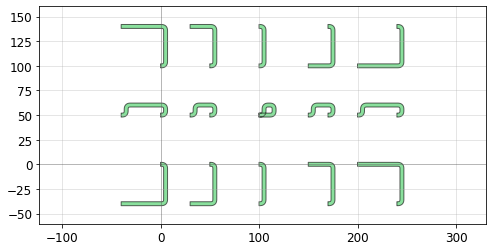

In [15]:
import numpy as np
from phidl import Device, quickplot as qp, set_quickplot_options
import phidl.routing as pr

set_quickplot_options(show_ports=False, show_subports=False)

D = Device() 
pitch = 50
xdevs = np.arange(5)*pitch
ydevs = np.arange(3)*pitch
xtest = np.linspace(-1*40, test_range, 5)
ytest = np.linspace(-1*40, test_range, 3)
for xidx, xdev in enumerate(xdevs):
    for yidx, ydev in enumerate(ydevs):
        devname = '{}{}'.format(xidx, yidx)
        port1 = D.add_port(name=devname+'1', midpoint=(xdev, ydev), width=4, orientation=0)
        port2 = D.add_port(name=devname+'2', midpoint=(xdev+xtest[xidx], ydev+ytest[yidx]), 
                           width=4,  orientation=0)
        D.add_ref(pr.route_smooth(port1, port2, route_type='manhattan'))
qp(D)